# Inicialização e Quebra de Empates da Q-Table (principalmente em ambientes estocásticos)

## Imports

In [58]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium   # conferir se precisa

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [59]:
import time
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from util.plot import plot_result
from util.qtable_helper import record_video_qtable, evaluate_qtable_policy
from util.notebook import display_videos_from_path
from util.experiments import repeated_exec
from util.plot import plot_multiple_results

import envs

In [60]:
# define se os algoritmos vão imprimir dados do treinamento
VERBOSE = True

## Monte Carlo V2

In [61]:
def choose_action(Q, state, num_actions, epsilon, random_tie_break=False):
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        # Encontrar os índices das ações com maior valor Q
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]

        if random_tie_break:
            return np.random.choice(best_actions)
        else:
            return best_actions[0]

In [62]:
# Algoritmo Monte-Carlo de Controle, variante "toda-visita".
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_montecarlo2(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, init_type="zero", random_tie_break=False, max_steps_per_episode=None):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zero,
    # usar o estado como índice das linhas e a ação como índice das colunas
    # Q = np.zeros(shape = (env.observation_space.n, num_actions))
    # Initialize Q-table
    if init_type == "zero":
        Q = np.zeros((env.observation_space.n, num_actions))
    elif init_type == "small_positive":
        Q = np.random.uniform(0, 0.01, (env.observation_space.n, num_actions))
    elif init_type == "small_range":
        Q = np.random.uniform(-0.01, 0.01, (env.observation_space.n, num_actions))
    else:
        raise ValueError("Invalid initialization type")

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0
        ep_trajectory = []

        state, _ = env.reset()
        steps = 0

        # [1] Executa um episódio completo, salvando a trajetória
        while not done:
            # [2] Escolhe a próxima ação -- usa epsilon-greedy
            action = choose_action(Q, state, num_actions, epsilon, random_tie_break=random_tie_break)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            steps += 1

            if env.spec.id == "CliffWalking-v0" and max_steps_per_episode is not None and steps >= max_steps_per_episode:
                done = True
            else:
                done = terminated or truncated

            # adiciona a tripla que representa este passo
            ep_trajectory.append( (state, action, reward) )

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if (i+1) % 100 == 0:
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            #print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

        # [3] Calcula os retornos parciais e atualiza Q
        Gt = 0
        for (s, a, r) in reversed(ep_trajectory):
            Gt = r + gamma*Gt
            # MODIFICAÇÂO SOLICITADA:
            Q[s,a] = (1.0 - lr)*Q[s,a] + lr*Gt

    return sum_rewards_per_ep, Q

## Q-Learning

In [63]:
def epsilon_greedy(Q, state, epsilon, random_tie_break=False):
    num_actions = len(Q[state])
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    elif random_tie_break:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]  # Ações ótimas
        return np.random.choice(best_actions)  # Escolha aleatória entre as melhores
    else:
        return np.argmax(Q[state])  # Escolha determinística

In [64]:
# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, init_type="zero", random_tie_break=False, max_steps_per_episode=None):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n
    render = False

     # Initialize Q-table
    if init_type == "zero":
        Q = np.zeros((env.observation_space.n, num_actions))
    elif init_type == "small_positive":
        Q = np.random.uniform(0, 0.01, (env.observation_space.n, num_actions))
    elif init_type == "small_range":
        Q = np.random.uniform(-0.01, 0.01, (env.observation_space.n, num_actions))
    else:
        raise ValueError("Invalid initialization type")

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        steps = 0

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon, random_tie_break)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            steps += 1

            if env.spec.id == "CliffWalking-v0" and max_steps_per_episode is not None and steps >= max_steps_per_episode:
                done = True
            else:
                done = terminated or trunc

            # Atualização da Q-table
            V_next_state = np.max(Q[next_state]) if not terminated else 0

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        #epsilon = np.exp(-0.005*i)

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            #print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

##Expected-Sarsa

In [65]:
# Função para Quebras de empate.
def epsilon_greedy_probs(Q, state, num_actions, epsilon, random_tie_break=False):
    probs = [ (epsilon / num_actions) ] * num_actions

    # Encontrar as ações ótimas (ações com o maior valor Q)
    best_actions = np.where(Q[state] == np.max(Q[state]))[0]

    if random_tie_break:
        # Se random_tie_break=True, distribui igualmente entre todas as ações ótimas
        prob_extra = (1.0 - epsilon) / len(best_actions)
        for a in best_actions:
            probs[a] += prob_extra
    else:
        # Se random_tie_break=False, atribui toda a probabilidade extra à ação de menor índice
        greedy_action = np.argmax(Q[state])
        probs[greedy_action] += (1.0 - epsilon)

    return probs

In [66]:
# Algoritmo Expected-SARSA
def run_expected_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, render=False, init_type="zero", random_tie_break=False, max_steps_per_episode=None):
    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    #Q = np.zeros(shape = (env.observation_space.n, num_actions))
    # Initialize Q-table
    if init_type == "zero":
        Q = np.zeros((env.observation_space.n, num_actions))
    elif init_type == "small_positive":
        Q = np.random.uniform(0, 0.01, (env.observation_space.n, num_actions))
    elif init_type == "small_range":
        Q = np.random.uniform(-0.01, 0.01, (env.observation_space.n, num_actions))
    else:
        raise ValueError("Invalid initialization type")

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        steps = 0

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon, random_tie_break)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            steps += 1

            # Aplica limite de passos apenas para CliffWalking-v0
            if env.spec.id == "CliffWalking-v0" and max_steps_per_episode is not None and steps >= max_steps_per_episode:
                done = True
            else:
                done = terminated or trunc


            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor esperado
                p_next_actions = epsilon_greedy_probs(Q, next_state, num_actions, epsilon, random_tie_break)
                V_next_state = np.sum( np.asarray(p_next_actions) * Q[next_state] )

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        # salva o retorno do episódio que encerrou
        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            #print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q


##Experimentos

**Função para executar os experimentos para cada combinação de algoritmo, ambiente, tipo de inicialização da Q-table e método de quebra de empate.**

In [68]:
# Função para executar os experimentos para cada combinação de algoritmo, ambiente, tipo de inicialização da Q-table e método de quebra de empate.

# Plotar o gráfico
def plot_result(algorithm, init_type, greedy, random, spacing=100):

  # Cria um array de índices espaçados
  indices = np.arange(0, len(greedy), spacing)

  # Seleciona os dados correspondentes
  greedy_spaced = np.array(greedy)[indices]
  random_spaced = np.array(random)[indices]

  plt.figure(figsize=(10, 6))
  plt.plot(indices, greedy_spaced, marker='o', linestyle='-', label="Menor Índice")
  plt.plot(indices, random_spaced, marker='s', linestyle='--', label="Escolha aleatória")
  plt.xlabel("Episodes")
  plt.ylabel("Soma de recompensas por episodio")
  plt.title(f"Quebra de Empate no Algoritmo {algorithm} com inicialização {init_type}")
  plt.legend()
  plt.grid(True)
  plt.show()

# Função para executar um experimento
def run_experiment(algorithm, env, init_type, episodes=1000, lr=0.1, gamma=0.95, epsilon=0.1):

    # Verifica se o ambiente é CliffWalking-v0 e define o limite de passos
    max_steps = 200 if env.spec.id == "CliffWalking-v0" else None

    # Seleciona o algoritmo
    if algorithm == "montecarlo":
        greedy_results, _ = run_montecarlo2(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=False, max_steps_per_episode=max_steps)
        random_results, _ = run_montecarlo2(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=True, max_steps_per_episode=max_steps)
    elif algorithm == "qlearning":
        greedy_results, _ = run_qlearning(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=False, max_steps_per_episode=max_steps)
        random_results, _ = run_qlearning(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=True, max_steps_per_episode=max_steps)
    elif algorithm == "expected_sarsa":
        greedy_results, _ = run_expected_sarsa(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=False, max_steps_per_episode=max_steps)
        random_results, _ = run_expected_sarsa(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=True, max_steps_per_episode=max_steps)
    else:
        raise ValueError("Algoritmo não reconhecido.")

    # Fecha o ambiente
    env.close()

    plot_result(algorithm, init_type, greedy_results, random_results, spacing=100)

    return greedy_results, random_results

def save_results(results, filename):
  df = pd.DataFrame(results)
  df.to_csv(filename, index=False)

###Monte Carlo

In [69]:
from sklearn.preprocessing import MinMaxScaler
import ast

def normalize_results(results):
  scaler = MinMaxScaler()
  normalized_results = scaler.fit_transform(np.array(results).reshape(-1, 1)).flatten()
  return normalized_results

def plot_comparison(results, init_types, spacing=100):
  plt.figure(figsize=(12, 8))

  for init_type in init_types:
    greedy_results = results[init_type]["greedy"]
    random_results = results[init_type]["random"]

    greedy_normalized = normalize_results(greedy_results)
    random_normalized = normalize_results(random_results)

    indices = np.arange(0, len(greedy_normalized), spacing)
    greedy_spaced = greedy_normalized[indices]
    random_spaced = random_normalized[indices]

    plt.plot(indices, greedy_spaced, marker='o', linestyle='-', label=f"{init_type} (Menor Índice)")
    plt.plot(indices, random_spaced, marker='s', linestyle='--', label=f"{init_type} (Escolha Aleatória)")

  plt.xlabel("Episodes")
  plt.ylabel("Recompensas Normalizadas")
  plt.title("Comparação de Inicializações e Métodos de Desempate")
  plt.legend()
  plt.grid(True)
  plt.show()


def load_results_from_csv(filename):
    df = pd.read_csv(filename)
    results = {}

    for _, row in df.iterrows():
        init_type = row["init_type"]
        greedy_results = ast.literal_eval(row["greedy_results"])
        random_results = ast.literal_eval(row["random_results"])

        results[init_type] = {
            "greedy": greedy_results,
            "random": random_results
        }

    return results

####Estocástico: FrozenLake-v1

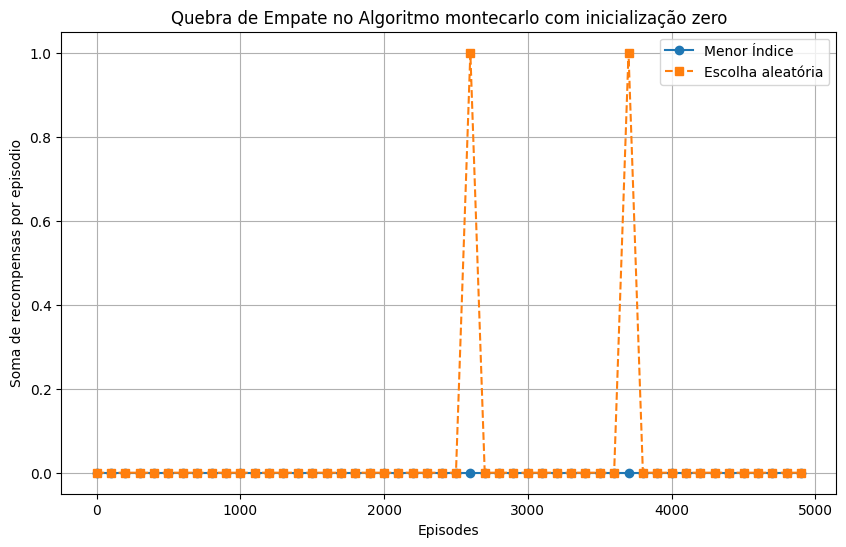

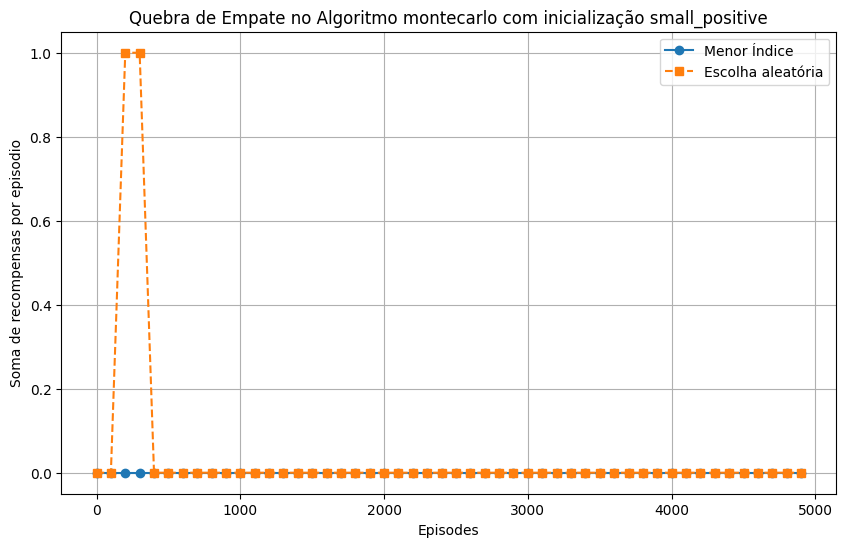

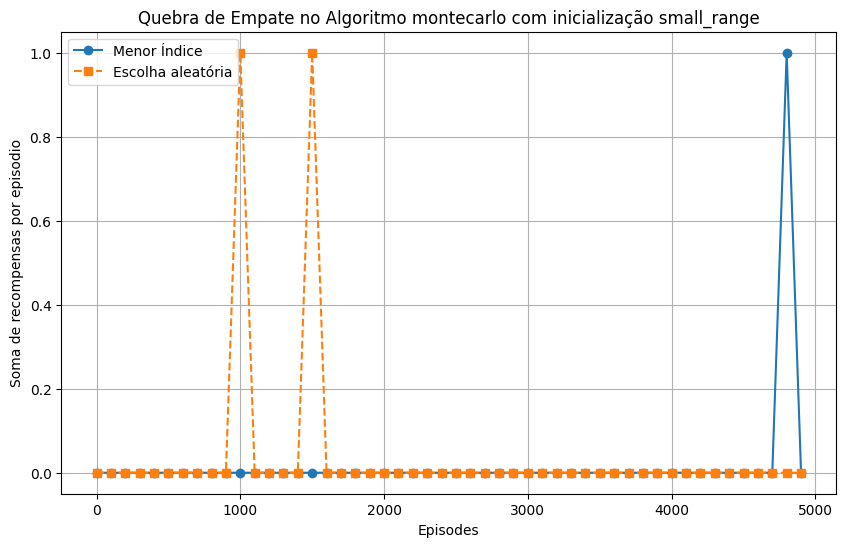

In [70]:
results_lake = []
env = gym.make("FrozenLake-v1", is_slippery=True)

init_types = ["zero", "small_positive", "small_range"]
for init_type in init_types:
  greedy_results, random_results = run_experiment("montecarlo", env, init_type, episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
  greedy_normalized = normalize_results(greedy_results)
  random_normalized = normalize_results(random_results)
  results_lake.append({
      "algorithm": "montecarlo",
      "env": "FrozenLake-v1",
      "init_type": init_type,
      "greedy_results": greedy_normalized,
      "random_results": random_normalized
  })

df_norm = pd.DataFrame(results_lake)

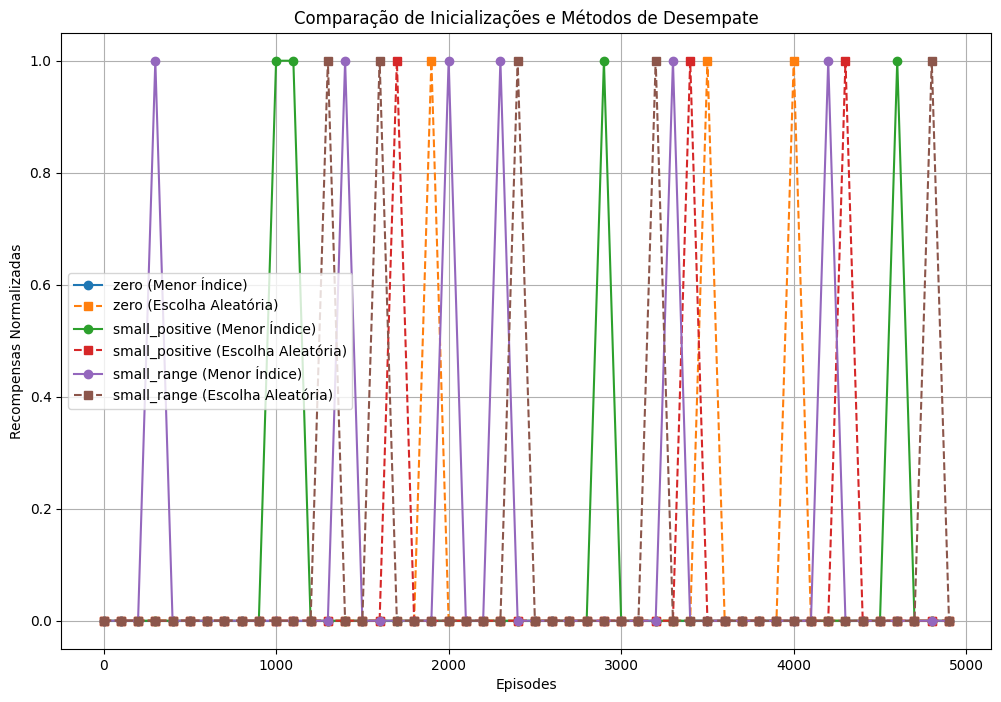

In [71]:
results_lake_csv = load_results_from_csv("montecarlo_lake.csv")

init_types = ["zero", "small_positive", "small_range"]

plot_comparison(results_lake_csv, init_types)

####Estocástico: RaceTrack-v0

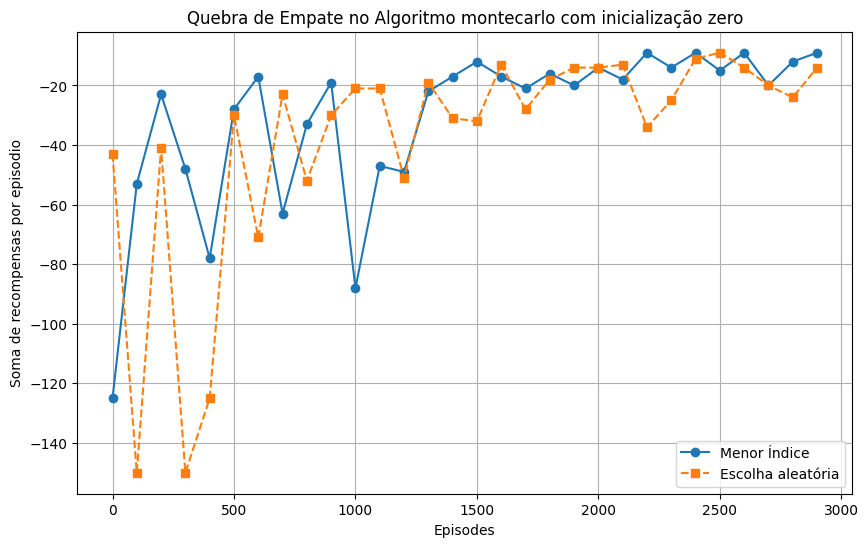

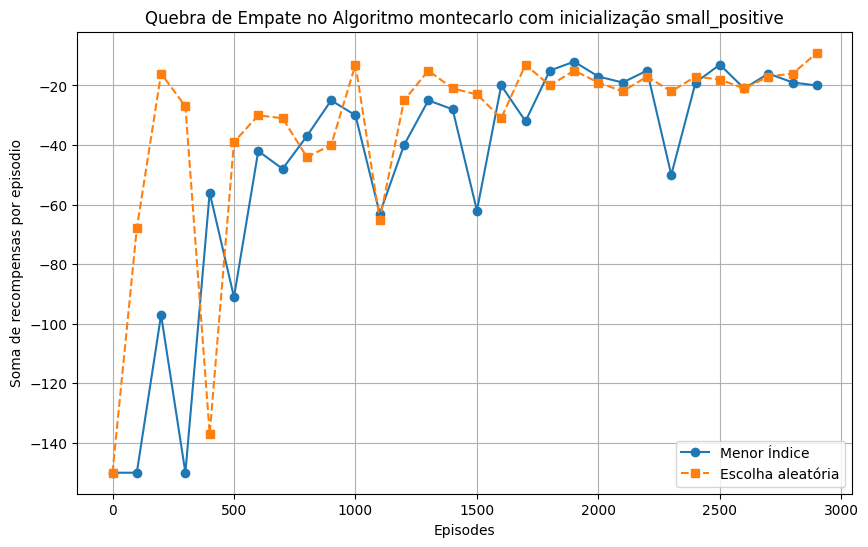

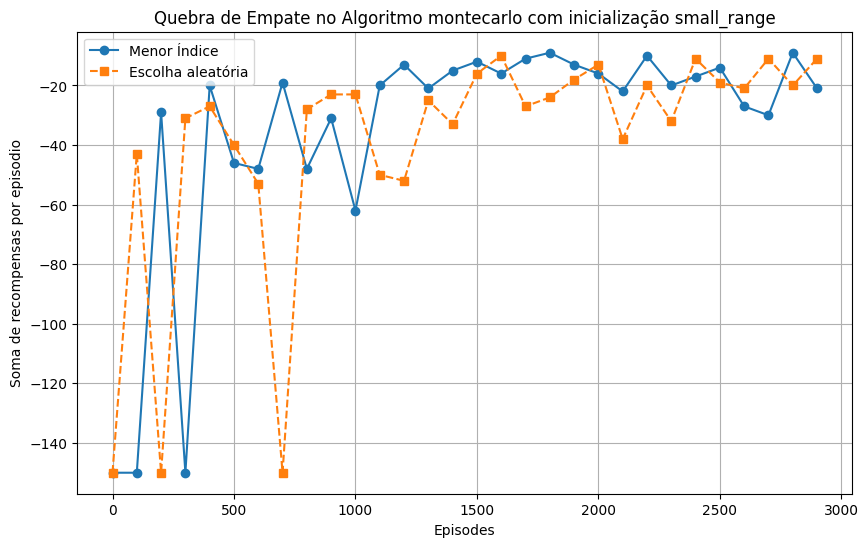

In [72]:
results_race = []
env = gym.make("RaceTrack-v0")

init_types = ["zero", "small_positive", "small_range"]
for init_type in init_types:
  greedy_results, random_results = run_experiment("montecarlo", env, init_type, episodes=3000, lr=0.1, gamma=0.95, epsilon=0.1)
  greedy_normalized = normalize_results(greedy_results)
  random_normalized = normalize_results(random_results)
  results_race.append({
      "algorithm": "montecarlo",
      "env": "RaceTrack-v0",
      "init_type": init_type,
      "greedy_results": greedy_normalized,
      "random_results": random_normalized
  })

# save_results(results_race, "montecarlo_race.csv")
df_norm = pd.concat([df_norm, pd.DataFrame(results_race)], ignore_index=True)

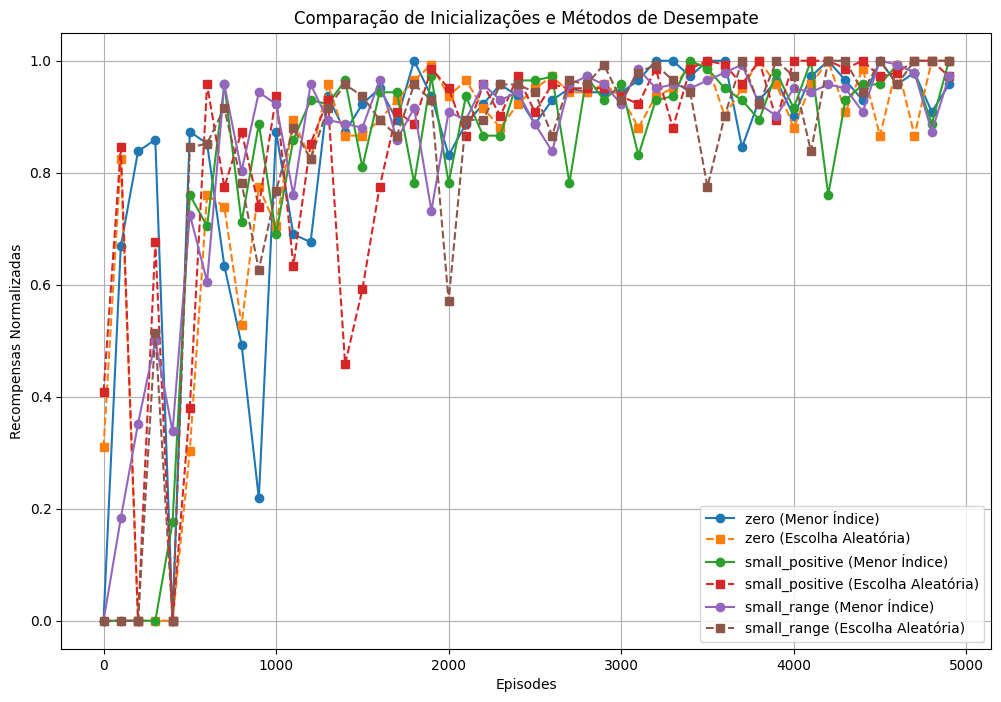

In [73]:
results_race_csv = load_results_from_csv("montecarlo_race.csv")

init_types = ["zero", "small_positive", "small_range"]

plot_comparison(results_race_csv, init_types)

###Q-Learning

####Estocástico: FrozenLake-v1

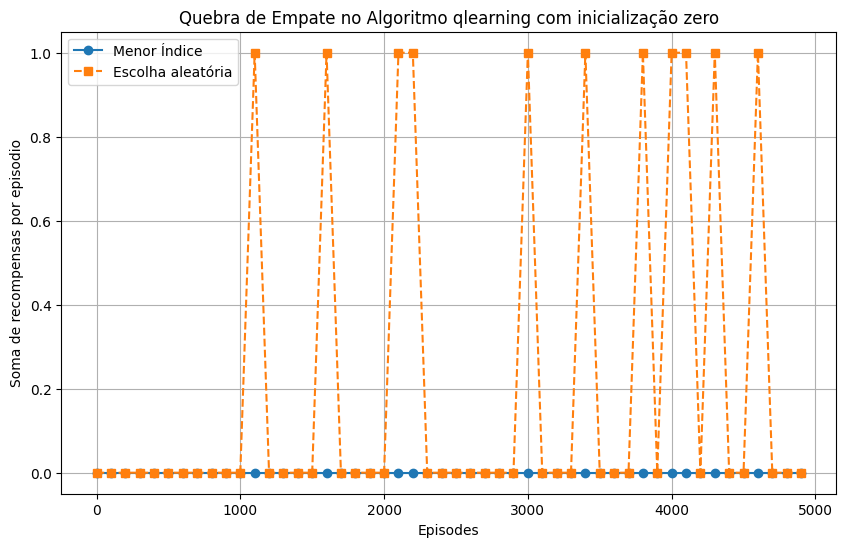

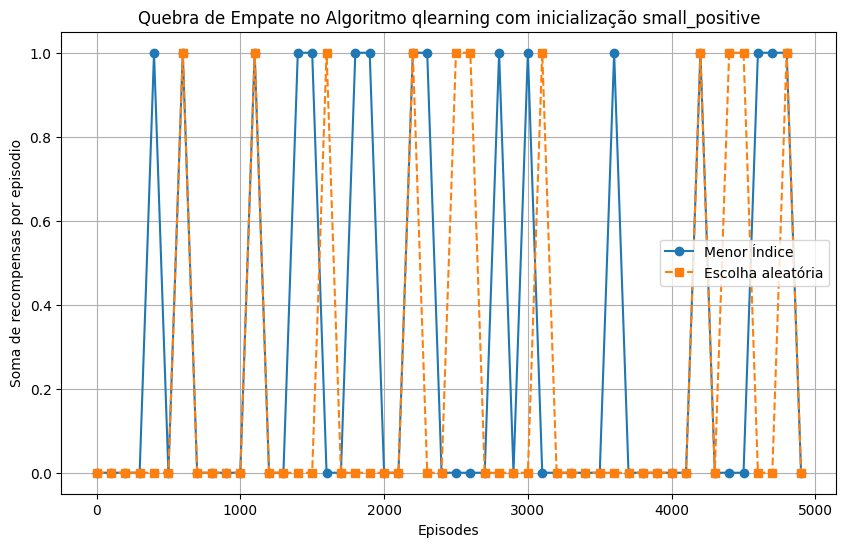

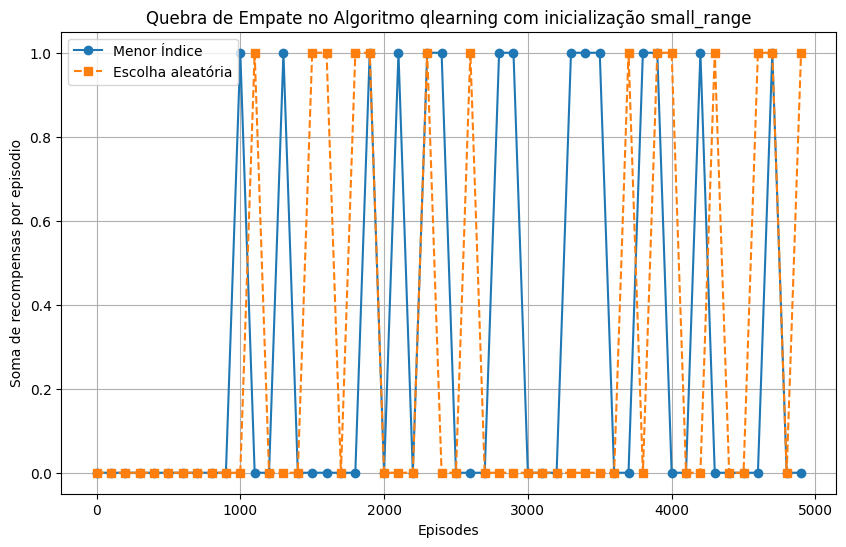

In [74]:
results_frozen_qlearn = []
env = gym.make("FrozenLake-v1")

init_types = ["zero", "small_positive", "small_range"]
for init_type in init_types:
  greedy_results, random_results = run_experiment("qlearning", env, init_type, episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
  greedy_normalized = normalize_results(greedy_results)
  random_normalized = normalize_results(random_results)
  results_frozen_qlearn.append({
      "algorithm": "qlearning",
      "env": "FrozenLake-v1",
      "init_type": init_type,
      "greedy_results": greedy_normalized,
      "random_results": random_normalized
  })

# save_results(results_race, "qlearning_lake.csv")
df_norm = pd.concat([df_norm, pd.DataFrame(results_frozen_qlearn)], ignore_index=True)

####Estocástico: RaceTrack-v0

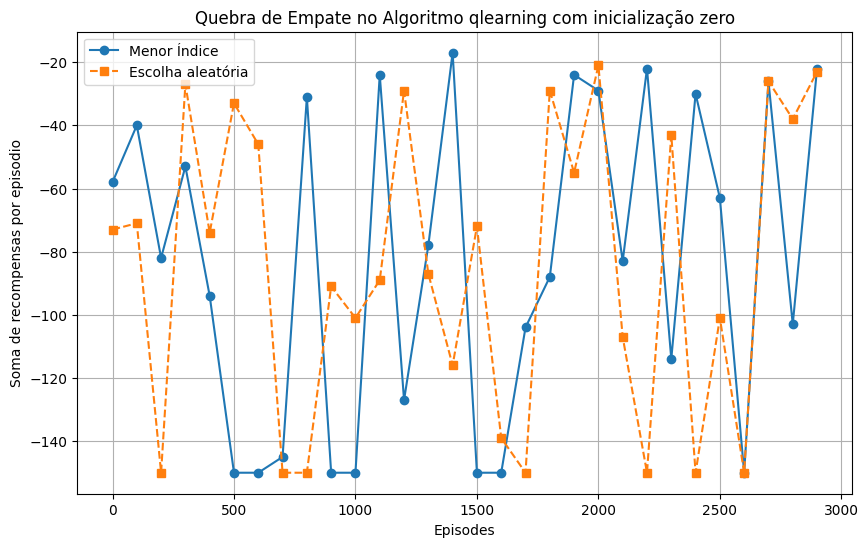

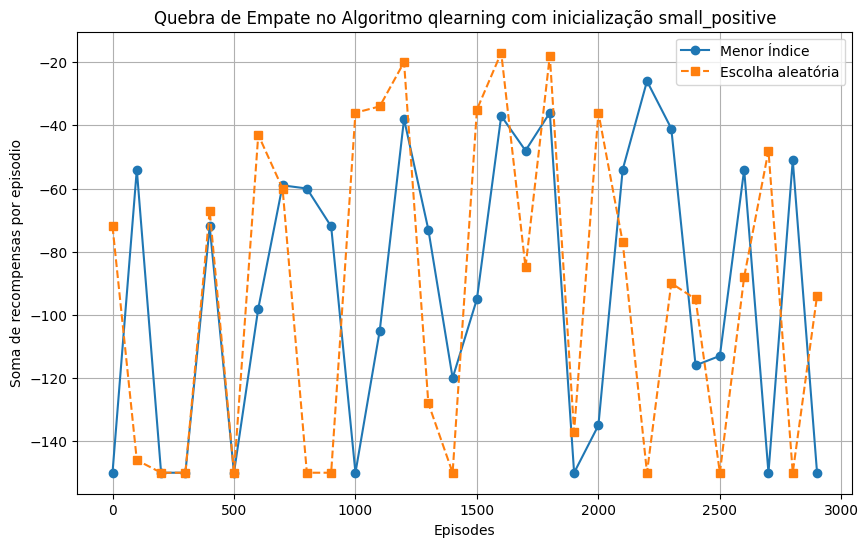

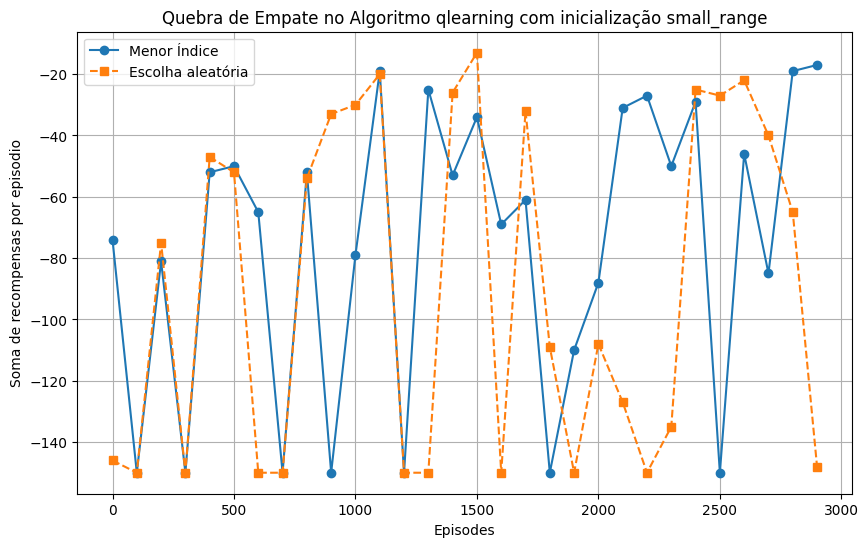

In [75]:
results_race_qlearn = []
env = gym.make("RaceTrack-v0")

init_types = ["zero", "small_positive", "small_range"]
for init_type in init_types:
  greedy_results, random_results = run_experiment("qlearning", env, init_type, episodes=3000, lr=0.1, gamma=0.95, epsilon=0.1)
  greedy_normalized = normalize_results(greedy_results)
  random_normalized = normalize_results(random_results)
  results_race_qlearn.append({
      "algorithm": "qlearning",
      "env": "RaceTrack-v0",
      "init_type": init_type,
      "greedy_results": greedy_normalized,
      "random_results": random_normalized
  })

# save_results(results_race, "qlearning_race.csv")
df_norm = pd.concat([df_norm, pd.DataFrame(results_race_qlearn)], ignore_index=True)

In [76]:
df_norm.to_csv("results.csv", index=False)
df_norm.head(20)

,algorithm,env,init_type,greedy_results,random_results
0,montecarlo,FrozenLake-v1,zero,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,montecarlo,FrozenLake-v1,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,montecarlo,FrozenLake-v1,small_range,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,montecarlo,RaceTrack-v0,zero,"[0.1760563380281689, 0.204225352112676, 0.0, 0...","[0.7535211267605633, 0.0, 0.5704225352112675, ..."
4,montecarlo,RaceTrack-v0,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.8943661971830985, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.40140845070422526, 0.0,..."
5,montecarlo,RaceTrack-v0,small_range,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.457...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.774..."
6,qlearning,FrozenLake-v1,zero,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,qlearning,FrozenLake-v1,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
8,qlearning,FrozenLake-v1,small_range,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,qlearning,RaceTrack-v0,zero,"[0.6571428571428571, 0.8214285714285714, 0.7, ...","[0.5422535211267605, 0.5633802816901408, 0.0, ..."


# Resultados

In [164]:
df = df_norm.copy()

## Plotagem Geral - Comparação entre os resultados dos tipos de inicialização e dos tipos de quebra de empate


In [166]:
# Média dos 100 últimos eps
def last_100_mean(results):
    if results.size == 0:
        return np.nan
    return np.mean(results[-100:])

df["greedy_mean_100"] = df["greedy_results"].apply(last_100_mean)
df["random_mean_100"] = df["random_results"].apply(last_100_mean)

In [167]:
df.head(5)

,algorithm,env,init_type,greedy_results,random_results,greedy_mean_100,random_mean_100
0,montecarlo,FrozenLake-v1,zero,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.030000
1,montecarlo,FrozenLake-v1,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.070000,0.070000
2,montecarlo,FrozenLake-v1,small_range,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.050000,0.080000
3,montecarlo,RaceTrack-v0,zero,"[0.1760563380281689, 0.204225352112676, 0.0, 0...","[0.7535211267605633, 0.0, 0.5704225352112675, ...",0.969930,0.945915
4,montecarlo,RaceTrack-v0,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.8943661971830985, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.40140845070422526, 0.0,...",0.932113,0.925493


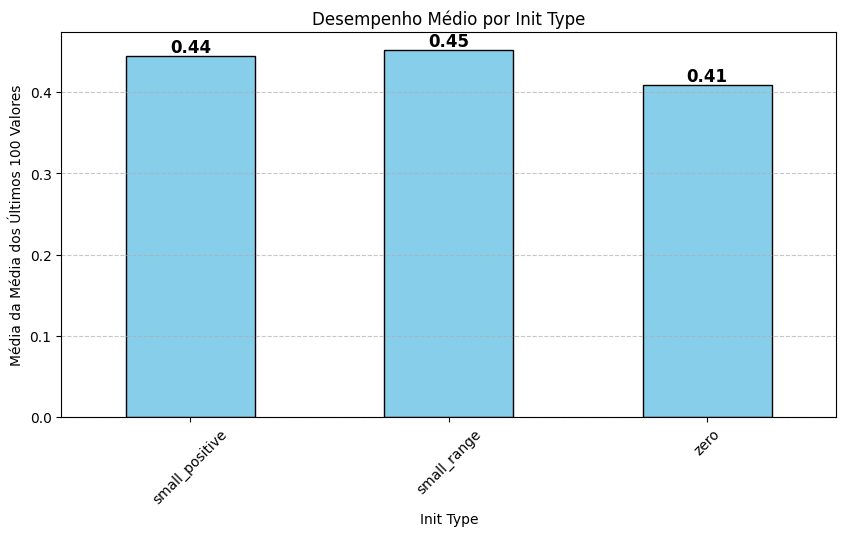

In [156]:
# Agrupar por init_type e calcular a média das médias
grouped_init = df.groupby("init_type")[["greedy_mean_100", "random_mean_100"]].mean()

# Plotagem
plt.figure(figsize=(10, 5))
bars = grouped_init.mean(axis=1).plot(kind="bar", color="skyblue", edgecolor="black")
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel("Init Type")
plt.ylabel("Média da Média dos Últimos 100 Valores")
plt.title("Desempenho Médio por Init Type")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

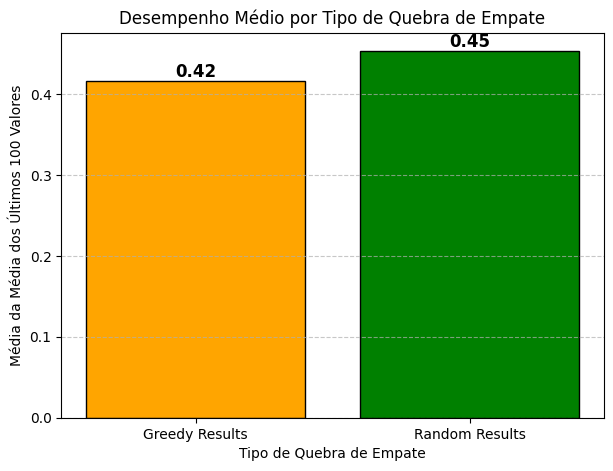

In [157]:
# Agrupar por quebra de empate e calcular a média das médias
grouped_tiebreak = {
    "Greedy Results": df["greedy_mean_100"].mean(),
    "Random Results": df["random_mean_100"].mean()
}

#Plotagem
plt.figure(figsize=(7, 5))
bars = plt.bar(grouped_tiebreak.keys(), grouped_tiebreak.values(), color=["orange", "green"], edgecolor="black")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel("Tipo de Quebra de Empate")
plt.ylabel("Média da Média dos Últimos 100 Valores")
plt.title("Desempenho Médio por Tipo de Quebra de Empate")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Plotagem por Ambiente - Comparando por quebra de empate:

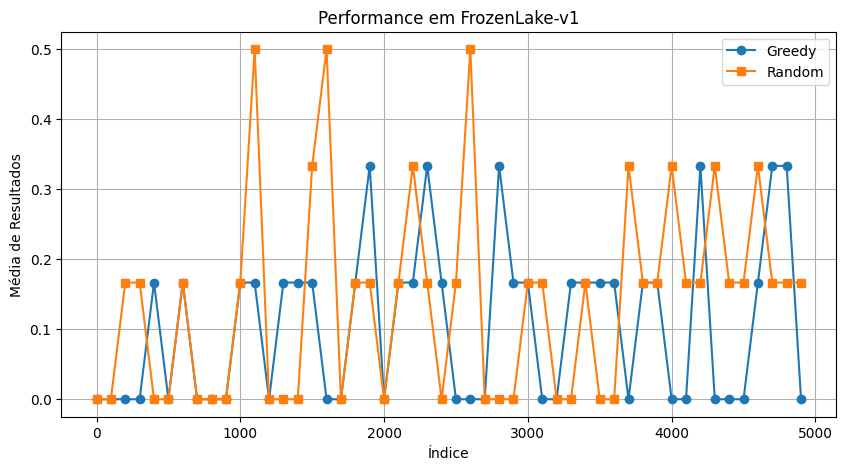

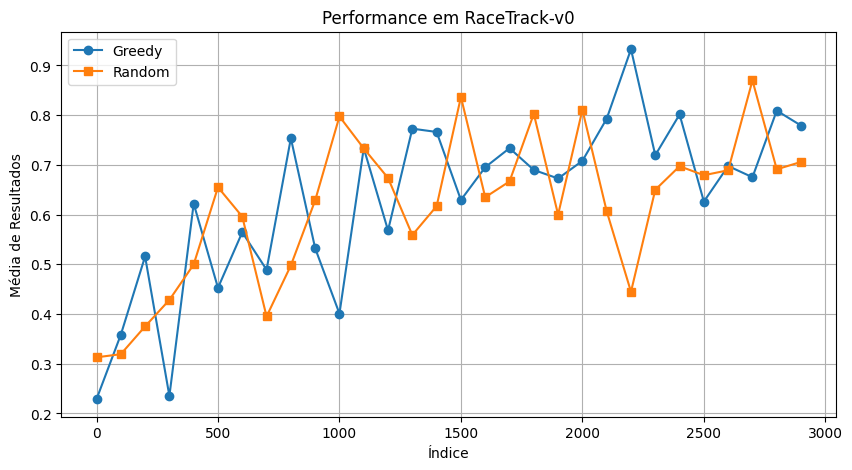

In [158]:
# Agrupar por ambiente e gerar novo array
aggregated_data = []
for env, group in df.groupby("env"):
    avg_greedy = np.mean(np.array(group["greedy_results"].tolist()), axis=0)
    avg_random = np.mean(np.array(group["random_results"].tolist()), axis=0)
    aggregated_data.append([env, group["init_type"].tolist(), avg_greedy.tolist(), avg_random.tolist()])

result_df = pd.DataFrame(aggregated_data, columns=["env", "init_types", "avg_greedy_results", "avg_random_results"])

# Gerar gráficos de linha para cada ambiente
for index, row in result_df.iterrows():
    avg_greedy = row['avg_greedy_results']
    avg_random = row['avg_random_results']
    indices = range(0, len(avg_greedy), 100)

    plt.figure(figsize=(10, 5))
    plt.plot(indices, avg_greedy[::100], label='Greedy', marker='o')
    plt.plot(indices, avg_random[::100], label='Random', marker='s')
    plt.title(f"Performance em {row['env']}")
    plt.xlabel("Índice")
    plt.ylabel("Média de Resultados")
    plt.legend()
    plt.grid()
    plt.show()

## Plotagem por Ambiente - Comparando as inicializações:


In [159]:
# Gerar nova coluna com as médias
def mean_by_index(df):
    df['avg_init'] = df.apply(lambda row: [(g + r) / 2 for g, r in zip(row['greedy_results'], row['random_results'])], axis=1)
    return df

df = mean_by_index(df)

In [162]:
df

,algorithm,env,init_type,greedy_results,random_results,greedy_mean_100,random_mean_100,avg_init
0,montecarlo,FrozenLake-v1,zero,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.030000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,montecarlo,FrozenLake-v1,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.070000,0.070000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,montecarlo,FrozenLake-v1,small_range,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.050000,0.080000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,montecarlo,RaceTrack-v0,zero,"[0.1760563380281689, 0.204225352112676, 0.0, 0...","[0.7535211267605633, 0.0, 0.5704225352112675, ...",0.969930,0.945915,"[0.4647887323943661, 0.102112676056338, 0.2852..."
4,montecarlo,RaceTrack-v0,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.8943661971830985, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.40140845070422526, 0.0,...",0.932113,0.925493,"[0.0, 0.0, 0.0, 0.0, 0.6478873239436619, 0.0, ..."
5,montecarlo,RaceTrack-v0,small_range,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.457...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.774...",0.962113,0.930775,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.616..."
6,qlearning,FrozenLake-v1,zero,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.320000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,qlearning,FrozenLake-v1,small_positive,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.300000,0.290000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ..."
8,qlearning,FrozenLake-v1,small_range,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.190000,0.360000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,qlearning,RaceTrack-v0,zero,"[0.6571428571428571, 0.8214285714285714, 0.7, ...","[0.5422535211267605, 0.5633802816901408, 0.0, ...",0.498429,0.507535,"[0.5996981891348088, 0.6924044265593561, 0.35,..."


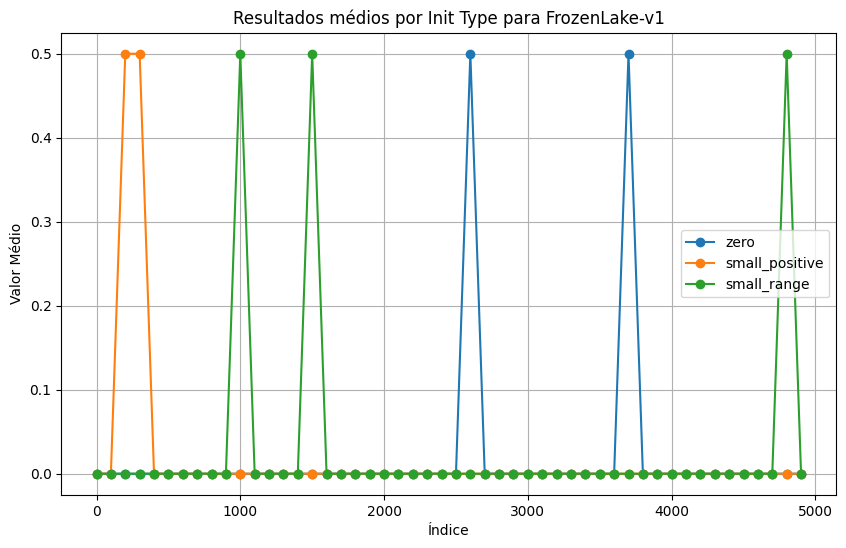

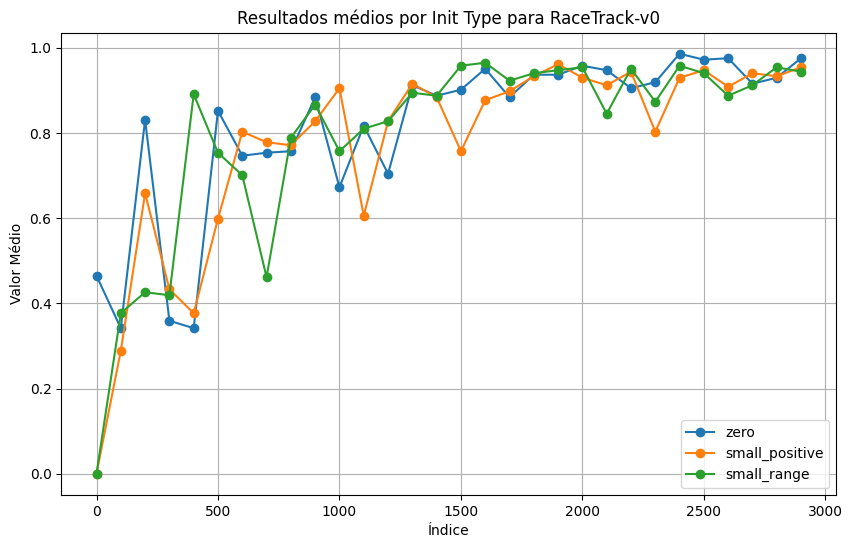

In [161]:
def plot_por_env(df):
    for env in df['env'].unique():
        plt.figure(figsize=(10, 6))
        df_env = df[df['env'] == env]
        for init_type in df_env['init_type'].unique():
            avg_values = df_env[df_env['init_type'] == init_type]['avg_init'].values[0]
            indices = range(0, len(avg_values), 100)
            plt.plot(indices, avg_values[::100], label=init_type, marker='o')

        plt.title(f'Resultados médios por Init Type para {env}')
        plt.xlabel('Índice')
        plt.ylabel('Valor Médio')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_por_env(df)